# A Little Bit of Inspiration
Recently, my Wallpapers were getting stale and wanted to find new ones to add more variety. This process is surprisingly annoying now even though I used to be willing to before. I no longer have as much interest in spending that time filtering. This reminded me of a blog post written by Jeff Atwood called [Your Desktop Is Not a Destination](https://blog.codinghorror.com/your-desktop-is-not-a-destination/) a long time ago where he talks about how he ignores his wallpapers entirely. It’s a short post and my first time reading it I mostly disagreed since I like the aesthetics of many wallpapers whenever they peek through; his post is not really about that as much as talking about how seeing the wallpaper just means you're not using your space efficiently. That also just sounds like another kind of busy work. Thankfully, with the advent of Convolutional Neural Networks and Deep Learning I should be able to teach a computer about the kinds of aesthetics I like and have the model select wallpapers for me.

## Overview and Folder Structure
For this project, we'll need some structure for where everything will go. We'll need:

1. A folder to contain the selected Wallpapers
2. A folder to contain the trained on wallpapers.
3. A folder to contain the deselected wallpapers.
4. A folder to contain the downloaded wallpapers.

Personally, I like to place the selected Wallpapers folder in my Dropbox that way it can be synced across multiple devices. With this setup, the selection and model building could be put on a server and done independently - which is a nice touch. You can use a different application than Dropbox if you don't like them or distrust them and want to use something else; maybe just a simply rsync cron to all your devices should work fine as well.

```bash
[shoklan@### Wallpapers]$ tree -d
.
├── Desktop
└── model
    ├── deselected
    ├── storage
    └── train

6 directories
```

My existing wallpapers are in the Desktop folder and the process will work under the `model` folder. That way I don't have to modify what exists and can build around it instead. The folder names are self explanatory in this instance with the exception of `storage`; this is where the downloaded files are going to end up when the files are downloaded.

Let's get this setup in Python.

In [1]:
import os
import pandas as pd
from PIL import Image
from io import BytesIO
from pathlib import Path

In [2]:
#| echo: false
dataPath = Path("../../_drafts/_data")

In [9]:
# Python pathlib is awesome
deselectedPath = Path('model/deselected')
storagePath = Path('model/storage')

if not (dataPath/deselectedPath).exists(): (dataPath/deselectedPath).mkdir()
if not (dataPath/storagePath).exists(): (dataPath/storagePath).mkdir()

In [4]:
# test and collect the existing images
targetFiles = sorted(
    list((dataPath/'Desktop').glob('*.png')) + 
    list((dataPath/'Desktop').glob('*.jpg')))

targetFiles = list(map( lambda x: 'Desktop/'+ x.parts[-1], targetFiles))
len(targetFiles)

41

## Dealing With the Wallhaven API
Now we will need a source for wallpapers with an accessible API. Personally, I really like [Wallhaven](https://wallhaven.cc) which is what I am using at this point. Their API is [publicly accessible](https://wallhaven.cc/help/api) as well which is nice for prototyping; please note that - like all public APIs - there is rate limiting in place and you should respect their wishes to not try to abuse the provided interface. Per the rules here, **API calls are currently limited to 45 per minute.** so do not be annoying and respect this. Even if you do not, then you'll just be stopped - and then eventually get blocked.

When you request images from this API without special specifications, you will always get the same set of 24 images on every request by default. While working through the API documentation to get unique results, I found that the `seed` does not appear to work so if you're planning on using it then do not. We'll be using pagination via the api since that will give us proper results.

In [5]:
import json
import requests

wallpaperAPI = 'https://wallhaven.cc/api/v1/search?'

# My specific wallpaper requirement
ratio ='16x9'
qRatio = f'ratios={ratio}'

We'll be using `requests` to download the data from the API which is a normal part of the python web work. Getting the data is as simple as:
```python
r = requests.get(wallpaperAPI + qRatio)
```

The results comes back as an HTML response object which contains lots of extra useful information; nothing we are interested in aside from the JSON API results. So, we'll want to simply pull the `.content` part of the response. Thankfully, pandas can accept the dictionary we're going to convert it into so this is very easy. Thanks Python!

In [6]:
r = requests.get(wallpaperAPI + qRatio)

tmp = pd.DataFrame(json.loads(r.content)['data'])
#tmp.head(10)
tmp = tmp.assign(
    ratio = tmp.ratio.astype(float)
)

# Just filtering out for columns I care about
tmp[['id', 'url', 'resolution', 'ratio', 'file_type', 'path']].head()

,id,url,resolution,ratio,file_type,path
0,l8jezr,https://wallhaven.cc/w/l8jezr,1920x1080,1.78,image/png,https://w.wallhaven.cc/full/l8/wallhaven-l8jez...
1,vqd7z5,https://wallhaven.cc/w/vqd7z5,1920x1080,1.78,image/png,https://w.wallhaven.cc/full/vq/wallhaven-vqd7z...
2,zyd18w,https://wallhaven.cc/w/zyd18w,5120x2880,1.78,image/jpeg,https://w.wallhaven.cc/full/zy/wallhaven-zyd18...
3,ex6d7l,https://wallhaven.cc/w/ex6d7l,6016x3385,1.78,image/png,https://w.wallhaven.cc/full/ex/wallhaven-ex6d7...
4,p97rkp,https://wallhaven.cc/w/p97rkp,6016x3384,1.78,image/png,https://w.wallhaven.cc/full/p9/wallhaven-p97rk...


There we go! Now we will need to download and convert the images to a format which Python can understand. Collecting this data is the same as collecting the JSON API data as we have that url named `path` from the JSON results. We're just going to write a function to deal with all this downloading and converting:

In [7]:
def collectImage( url ):
    return Image.open(
        BytesIO(requests.get(url).content))\
        .convert('RGB')

And, since we cannot recieve more than 24 images per request we will need to write a loop to iterate through the `path` results and download them. Per iteration, we will combine the image data and the row being iterated over to keep the data, reference and image together. At the end of the loop, all the collected data frames will be combined into a single final data frame to work with.

In [10]:
imgs = []
frames = []
count = 1

# I lowered this for the post; it's usually 100
while len(imgs) < 47:
    r = requests.get( wallpaperAPI + qRatio + f'&page={count}')
    tmp = pd.DataFrame(json.loads(r.content)['data'])

    frames += [tmp]
    collection = [ collectImage( url ) for _, url in tmp.path.items() ]
    imgs = imgs + collection
    print(f'Length of the collection is {len(imgs)}.')
    count += 1

# Join all the collected image data as a dataframe
df = pd.concat(frames).reset_index(drop=True)

Length of the collection is 24.
Length of the collection is 48.


In [11]:
df.id.nunique(), len( df )

(48, 48)

Next we will need to download them to the local file system so they can be used for modeling - which is just another for loop. Note that I am using `zfill` which is a convenient python string function to pad out numbers when converting to strings; I learned this lesson once already to make sure the sorting in the filesystem is the same as when opening the images to label them.

In [12]:
# iterate through our results and export/name the images
for i,r in df.iterrows():
    imgs[i].save(str(dataPath/storagePath/str(i).zfill(4)) + '.' + r.file_type.split('/')[-1])

## Building the Dataset for Training
Fastai allows quite a few ways to load the images for training however I'm partial to the older method of notating a CSV files. We'll be mixing that with the slightly newer way of loading the training information via data frame. All the different images will have the same columns so we can just create a template data frame and clone it to fill per directory.

In [13]:
# Setup versions
template = pd.DataFrame(columns=['fname', 'label'])

# labels will be the final; downloaded is filled out by me.
labels = template.copy()
downloaded = template.copy()
removed = template.copy()

We'll start with the images to be removed. 

Each folder can be processed using the same pattern for the downloaded files so we will go over this once and just repeat it.
The files in each folder need to be iterated over and the full paths pruned. This is because if we only use the filename when we try to use the images from the loader it will fail to find anything. Pruning the files down from the full path will give us a relative path and then when the data loader looks for the files then they *can* be found. Luckily, `pathlib` allows us to retrieve the full path as a tuple using `filename.parts` and pull off the end however much is necessary.

The whole list will be sorted based on the name of the files to ensure the filesystem folder and the soon to be exported rows in the CSV match. The `sort` function allows us to set our own sort method so we'll steal the filename off the end and feed that into `sort()`.

Lastly, we can set the current wallpapers to `YES` and the deselected wallpapers to `NO` respectively when we import them.

In [14]:
# Remove wallpapers I don't care about anymore
removedFiles = sorted(
    [ '/'.join(f.parts[-3:]) for f in (dataPath/deselectedPath).iterdir() ],
    key = lambda x: x.split('/')[-1])
removed['fname'] = removedFiles
removed['label'] = 'NO'

For the downloaded files from the API, we'll do the same thing but we will leave the `label` column blank to manually label them.

In [15]:
downloadedFiles = sorted(
    [ '/'.join(f.parts[-3:]) for f in (dataPath/storagePath).iterdir() ],
    key = lambda x: x.split('/')[-1])
downloaded['fname'] = downloadedFiles
downloaded.to_csv(dataPath/'model/downloaded.csv', index=False)

You can open this CSV file however and once annotated we will pull it back in.

In [16]:
filledOut = pd.read_csv(dataPath/'model/downloaded.csv')
filledOut.head(15)

,fname,label
0,model/storage/0000.png,YES
1,model/storage/0001.png,YES
2,model/storage/0002.jpeg,YES
3,model/storage/0003.png,NO
4,model/storage/0004.png,NO
5,model/storage/0005.jpeg,NO
6,model/storage/0006.jpeg,NO
7,model/storage/0007.jpeg,NO
8,model/storage/0008.png,NO
9,model/storage/0009.png,NO


Everything in the directory of existing wallpapers is a `YES` we just quickly set those. And finally, we add them all together into a single collection of images and labels.

In [17]:
labels['fname'] = targetFiles
labels['label'] = 'YES'

selections = pd.concat([labels, filledOut, removed])
selections.label.value_counts()

YES    48
NO     41
Name: label, dtype: int64

Note that if there are no rows in one of these data frames then it appends empty and those *rows* do not show up; they simply get ignored since they are empty.

## Training the Model
We at last come to what should be the easiest part of doing all this. Thanks to all the wonderful tooling that exists now - Thanks Jeremy and community! - we can import the kind of learner we're after and simply tell it what we want.

In [18]:
from fastcore.all import *
from fastai.vision.all import *     # This is for the CNN learner.

Fastai has a smart wrapper around Pytorch's data loader - which I've looked at in the past a bit - which we'll use to tell it where the files are. Since these are very large images, some resizing needs to be done to fit all the batches onto my own GPU. If you decide to follow along then continue to scale down the images until they fit on yours; try to keep the aspect ratio the same just so it doesn't distort it too much.

In [23]:
dls = ImageDataLoaders.from_df(selections, dataPath, item_tfms=Resize((1080//4, 1920//4)), valid_pct=.25)

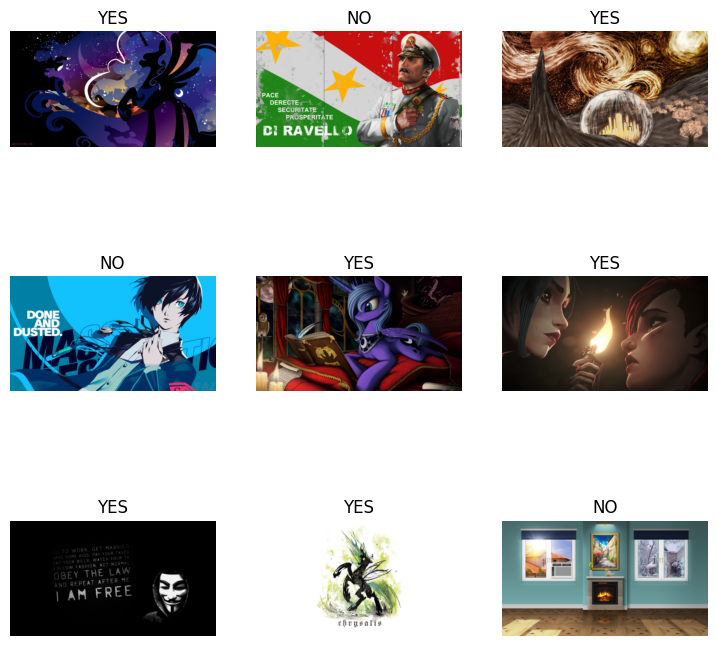

In [24]:
dls.show_batch()

And, now we learn.

In [26]:
# semicolon is to suppress warnings here
# .to_fp16() actually made this even worse then it was, somehow
learn = vision_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(valley=0.0014454397605732083)

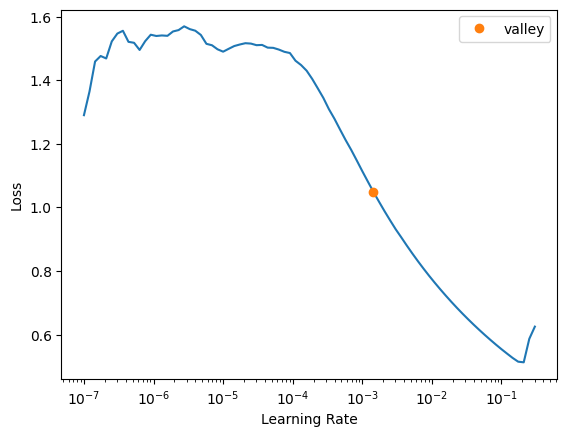

In [27]:
learn.lr_find()

In [31]:
# This is overfitting pretty badly; will need to fix this
## Weight decay makes this even worse
## I ended up extending out the number of cycles since I was making solid gains to validation loss
learn.fine_tune(12, .0015)

I wanted to show the training but somehow it is not printing in my setup so we'll substitute this with some interpretation information instead. 

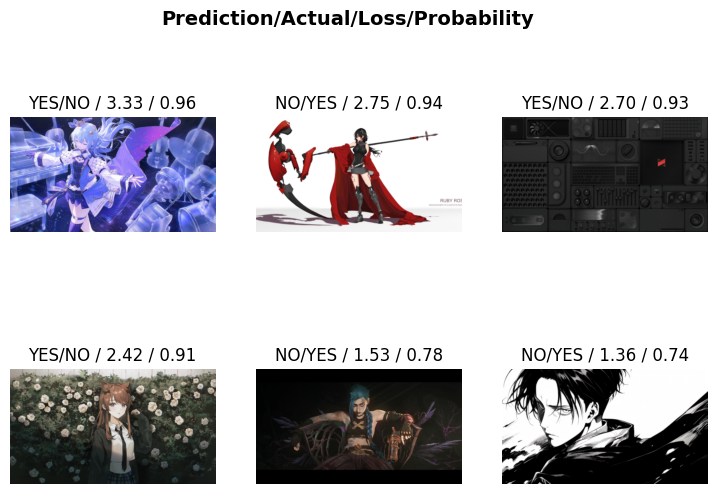

In [32]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(6)

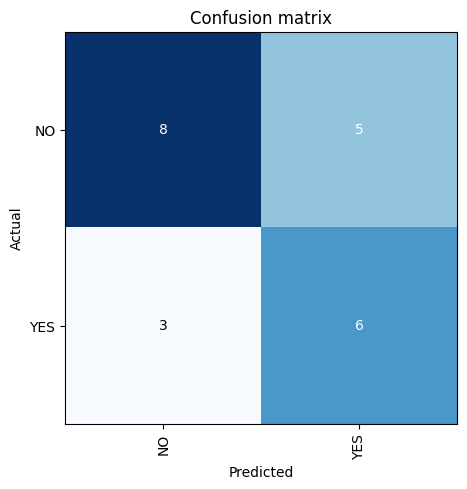

In [33]:
cInterp = ClassificationInterpretation.from_learner(learn)
cInterp.plot_confusion_matrix()

The calculated accuracy here is 60%.

That means our model did a little better than random chance at picking which wallpapers I would accept. This actually is not terrible considering what I am asking of it. Most tasks these models are trained on have clear labels about what something should and should not be. Telling a cat or dog apart is easy; telling apart my taste in wallpapers is not so easy.

For example, some of my wallpapers have women in them and some of them do not; some of them are quite dark and some of them are not; some of them are simply quotations and some of them are not. Some of them are anime related and some of them are not. Simply because a wallpaper has an art style which would be considered anime does not mean it gets a `YES`. Taste is a hard problem and I would be surprised if it could accurately predict mine.

Also, the model is surprising more forgiving about the `YES` than the `No` which means I am likely to end up with results I did not expect. Since the purpose is to save me time finding wallpapers I might like then this is a nice bonus about this model. And, removing a wallpaper is a built into the process already so the cost of being wrong is tiny in time lost.

Now all we have to do is save them model so we can use it in a script running a scheduled task.

In [34]:
# modelName = 'prototype'
modelName = 'model-0.1'
learn.export(dataPath/f'model/{modelName}')

In [36]:
nLearn = load_learner(dataPath/f'model/{modelName}')
print(nLearn.predict(dataPath/targetFiles[0])[0])

YES


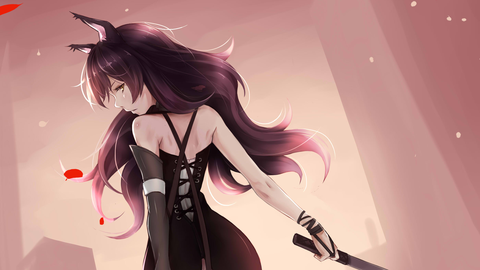

In [48]:
# This is definitely a yes
Image.open(dataPath/targetFiles[0]).resize((1920//4, 1080//4), Image.ANTIALIAS)

## Future Features
While all this is nice, there are some improvements I would like in the next iteration.

For one, it would be nice to shuffle the images around so that only a subset are used at any one time. This way I can slow down the rate it downloads them while still keeping most images novel for longer. If I am downloading over a hundred images every month then I will quickly end up with thousands of images and that is not what I want. Perhaps I could use the confidence of the predictions in some way to assist with pruning out images.

Another is that I will need to keep a good number of confidently confirmed `NO` label images but those take up valuable space. Developing a sort of data structure or class which wraps around compressed references to the images and then extracts just the asked for images at run time. This way, I can minimize the image space used as well as continue to use them for training.

Lastly, this simple model version is ok but a multi-class version which contains categories - such as car - and then filter them out immediately would be better. Changing the model might be better or worse depending on how much trouble it is to manage the different labels. We might also be able to use these to assist with labeling the image files since generic numbers and IDs will make finding images painful.